TODO: Fix Error below

## Chassis Example Notebooks
Welcome to the examples section for [Chassis](https://chassis.ml), which contains notebooks that auto-containerize models built using the most common machine learning (ML) frameworks. 

#### What is Chassis?
Chassis allows you to automatically create a Docker container from your model code and push that container image to a Docker registry. All you need is your model loaded into memory and a few lines of Chassis code! Our example bank is here to provide reference examples for many common ML frameworks.  

Can't find the framework you are looking for or need help? Fork this repository and open a PR, or list the desired framework in a new issue. We're always interested in growing this example bank! 

The primary maintainers of Chassis also actively monitor our [Discord Server](https://discord.gg/cHpzY9yCcM), so feel free to join and ask any questions you might have. We'll be there to respond and help out promptly.

In [1]:
import os
import math
import json
import chassisml
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from io import StringIO
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import norm

## Enter credentials
Dockerhub creds and Modzy API Key

In [2]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')

docker hub username········
docker hub password········


## Data Engineering

In [3]:
# load house price dataset
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1460, 81), test: (1459, 80)


In [4]:
df_train.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
438,439,30,RL,40.0,4280,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2007,WD,Normal,90350
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
202,203,50,RL,50.0,7000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,COD,Normal,112000


In [5]:
# preprocess data
df_na = (df_train.isnull().sum() / len(df_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


C:\tools\Anaconda3\envs\modzy\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\tools\Anaconda3\envs\modzy\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

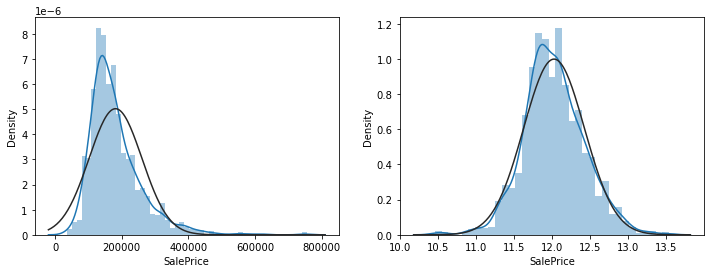

In [6]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df_train['SalePrice'], ax=ax[0], fit=norm)
sns.distplot(np.log(df_train[('SalePrice')]+1), ax=ax[1], fit= norm)

In [7]:
def fill_missing(df, cols, val):
    """ Fill with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

In [8]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

df_train = addlogs(df_train, loglist)
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

In [9]:
fill_missing(df_train, ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       "MasVnrType", "MSSubClass"], "None")
fill_missing(df_train, ["GarageYrBlt", "GarageArea", "GarageCars",
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                       "MasVnrArea"], 0)
fill_missing_with_mode(df_train, ["MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"])
fill_missing(df_train, ["Functional"],"Typ")
# Utils is pointless as there is only one row with a value
df_train.drop(['Utilities'], axis=1, inplace=True)
# For lot frontage we take the median of the neighbourhood. In general this would be a good approximation as most 
# house co located are similar in size 
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [10]:
df_train.drop(df_train[(df_train['OverallQual']<5) & (df_train['SalePrice']>200000)].index, inplace=True)
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

In [11]:
def fix_missing_cols(in_train, in_test):
    missing_cols = set(in_train.columns) - set(in_test.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    in_test = in_test[in_train.columns]
    return in_test

def dummy_encode(in_df_train, in_df_test):
    df_train = in_df_train
    df_test = in_df_test
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object'
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = pd.concat([df_test, pd.get_dummies(df_test[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = fix_missing_cols(df_train, df_test)
    return df_train, df_test

In [12]:
df_train, df_test = dummy_encode(df_train, df_test)
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Shape train: (1456, 361), test: (1459, 361)


In [13]:
def load_poly_features(df_train, df_test, cols):
    """
    USeful function to generate poly terms
    :param df_train: The training data frame
    :param df_test: The test data frame
    :return: df_poly_features, df_poly_features_test - The training polynomial features + the test
    """
    print('Loading polynomial features..')
    # Make a new dataframe for polynomial features
    poly_features = df_train[cols]
    poly_features_test = df_test[cols]

    # imputer for handling missing values
    imputer = SimpleImputer(strategy='median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)
    poly_features_test = imputer.transform(poly_features_test)

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=3)
    # Train the polynomial features
    poly_transformer.fit(poly_features)

    # Transform the features
    poly_features = poly_transformer.transform(poly_features)
    poly_features_test = poly_transformer.transform(poly_features_test)
    print('Polynomial Features shape: %s' % str(poly_features.shape))

    df_poly_features = pd.DataFrame(poly_features,
                                    columns=poly_transformer.get_feature_names(cols))
    df_poly_features_test = pd.DataFrame(poly_features_test,
                                         columns=poly_transformer.get_feature_names(cols))
    df_poly_features['Id'] = df_train['Id']
    df_poly_features_test['Id'] = df_test['Id']
    print('Loaded polynomial features')
    return df_poly_features, df_poly_features_test

In [14]:
correlated_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']
df_train_poly, df_test_poly =  load_poly_features(df_train, df_test, cols=correlated_cols)
print("Shape train: %s, test: %s" % (df_train_poly.shape, df_test_poly.shape))

Loading polynomial features..
Polynomial Features shape: (1456, 84)


AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'

In [ ]:
df_train = df_train.merge(right=df_train_poly.reset_index(), how='left', on='Id')
df_test = df_test.merge(right=df_test_poly.reset_index(), how='left', on='Id')
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

In [15]:
y = df_train["SalePrice"]
y.sample(3)

467    11.894788
400    12.411056
300    11.964007
Name: SalePrice, dtype: float64

In [43]:
df_train.drop(["SalePrice"], axis=1, inplace=True)
# The fix missing cols above will have added the target column to the test data frame, so this is a workaround to remove it
df_test.drop(["SalePrice"], axis=1, inplace=True) 
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1456, 445), test: (1459, 445)


In [45]:
X_train, X_test, y_train, y_test = train_test_split( df_train, y, test_size=0.2, random_state=42)
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [46]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

In [48]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [49]:
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.00315


In [57]:
test_pred = np.expm1(gbm.predict(df_test, num_iteration=gbm.best_iteration_))

In [61]:
# save sample data for testing
with open("./data/house_costs_sample.csv", "w") as sample_out:
    df_test[:10].to_csv(sample_out, index=False)

## Write process function

* Must take bytes as input
* Preprocess bytes, run inference, postprocess model output, return results

In [71]:
def process(input_bytes):
    inputs = pd.read_csv(StringIO(str(input_bytes, "utf-8")))
    preds = np.expm1(gbm.predict(inputs, num_iteration=gbm.best_iteration_))
    
    inference_result = {
        "costPredictions": [
            {"house": i+1, "cost": pred} for i, pred in enumerate(preds)
        ]
    }
    
    structured_output = {
        "data": {
            "result": inference_result,
            "explanation": None,
            "drift": None,
        }
    }
    
    return structured_output

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [72]:
chassis_client = chassisml.ChassisClient("http://localhost:5000")

## Create and test Chassis model
* Requires `process_fn` defined above

In [74]:
# create Chassis model
chassis_model = chassis_client.create_model(process_fn=process)

# test Chassis model locally (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/house_costs_sample.csv'
results = chassis_model.test(sample_filepath)
print(results)

b'{"data":{"result":{"costPredictions":[{"house":1,"cost":125291.13397091045},{"house":2,"cost":151243.23557382918},{"house":3,"cost":178881.75963017135},{"house":4,"cost":179441.95798803744},{"house":5,"cost":176552.3993226991},{"house":6,"cost":172862.2578119226},{"house":7,"cost":171079.47671552232},{"house":8,"cost":165387.66148937555},{"house":9,"cost":178519.63148438587},{"house":10,"cost":113122.67807656695}]},"explanation":null,"drift":null}}'


In [75]:
# test environment and model within Chassis service, must pass filepath here:

# dry run before build
test_env_result = chassis_model.test_env(sample_filepath)
print(test_env_result)

Starting test job... Ok!
{'model_output': 'Single input prediction:\n\nb\'{"data":{"result":{"costPredictions":[{"house":1,"cost":125291.13397091045},{"house":2,"cost":151243.23557382918},{"house":3,"cost":178881.75963017135},{"house":4,"cost":179441.95798803744},{"house":5,"cost":176552.3993226991},{"house":6,"cost":172862.2578119226},{"house":7,"cost":171079.47671552235},{"house":8,"cost":165387.66148937555},{"house":9,"cost":178519.63148438587},{"house":10,"cost":113122.67807656695}]},"explanation":null,"drift":null}}\'\n'}


## Publish model to Docker
Need to provide model name, model version, and Dockerhub credentials

In [76]:
response = chassis_model.publish(
    model_name="Chassis LightGBM House Price Regression",
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
)

job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)

Starting build job... Ok!


In [77]:
if chassis_client.get_job_status(job_id)["result"] is not None:
    print("New model URL: {}".format(chassis_client.get_job_status(job_id)["result"]["container_url"]))
else:
    print("Chassis job failed \n\n {}".format(chassis_client.get_job_status(job_id)))

New model URL: https://integration.modzy.engineering/models/suo2xen59n/0.0.1
